In [400]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload

import utils
import persim
import itertools

from sklearn import manifold, cluster
from gudhi.wasserstein import wasserstein_distance
import tifffile as tf
from scipy import ndimage,stats

In [2]:
seed = 42
SCALE = 256
ndims = 3
minlife = 0.5
nrows, ncols = 2,3
fs = 14
PP = 10
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#e0e0e0', '#56b4e9', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#f0e442', '#000000']
cmap = ['Greys_r', 'Blues_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'

sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col=0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
weight = np.load(ksrc + sample + '_border_weights.npy', allow_pickle=True)
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
wall[tf.imread(nsrc + sample + '_EDT.tif') < 1] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

handles = [None for _ in range(len(Genes))]
for i in range(len(handles)):
    handles[i] = mlines.Line2D([], [], mfc=color[i], marker=marker[i], ls='None', mec='k', mew=1, ms=7)

In [3]:
normtype = 'both'
level = 'sup'
Bname = '{}level persistence. {} normalized.'.format(level.title(), normtype.title())

gsrc = '../{}level/'.format(level) + sample + os.sep

foo = glob(gsrc + transcriptomes[Genes[0]] + os.sep + '*')[0]
bar = os.path.split(foo)[1].split('_')
PP = int(bar[4][1:])
stepsize = int(bar[5][1:])
bw = int(bar[6][2:])
zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

jsonfiles = [ [ None for j in range(len(Cells)) ] for i in range(len(Genes)) ]
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]
ratios = utils.normalize_counts(transfocus, normtype)
if ratios is None:
    print('ERROR')

print('Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
print(np.sum(ratios > 0, axis=1))
print(transfocus.sum(axis='columns'), '\n')

# [gene][cell][dimension]

orig_diags = [None for i in range(len(jsonfiles))]
for i in range(len(orig_diags)):
    orig_diags[i] = utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True)

orig_diags, rescale, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)
diags, nzcumsum, nzmask = utils.reduce_num_of_diagrams(orig_diags, rescale, focus_dim, normtype, minlife=minlife, keepall=True)
print(list(map(len, diags)))

Max ratio by both:	0.24%
[968 950 956 464 960 968]
gene
GLYMA_17G195900    698882
GLYMA_05G216000     12919
GLYMA_17G185800     11462
GLYMA_05G203100      4116
GLYMA_15G210100     11688
GLYMA_05G092200    479091
dtype: int64 

Initial number of life-birth pairs	: 159902

No. of diagrams s.t. H_k had the most persistent component
H_0:	5748 [ 99.0% ]
H_1:	60 [ 1.0% ]
H_2:	0 [ 0.0% ]

Will focus just on dimension k = 0

Non-zero diagrams:	5808
Compared to all diagrams:	5808	[100.00%]
[968, 968, 968, 968, 968, 968]


# 1-Wasserstein Distance between Persistence Diagrams

In [4]:
ws_o = 1
internal_p = np.inf
if internal_p == np.inf:
    ws_p = '\\infty'
else:
    ws_p = str(internal_p)

it = list(itertools.combinations(range(len(Genes)), 2))
columns = np.asarray([ '{}_-_vs_-_{}'.format(transcriptomes[Genes[foo[0]]],transcriptomes[Genes[foo[1]]]) for foo in it])
filename = isrc + 'wasserstein{}d_{}_-_{}level_-_by_{}'.format(ws_o, ws_p.replace('\\',''), level, normtype)

if not os.path.isfile(filename + '.csv'):
    
    ws1 = pd.DataFrame(np.full((len(Cells), len(it)), np.nan), index=Cells, columns=columns)
    dmatch = dict()
    
    for i in range(len(Cells)):
        for foo in it:
            comp = '{}_-_vs_-_{}'.format(transcriptomes[Genes[foo[0]]],transcriptomes[Genes[foo[1]]])
            if len(diags[foo[0]][i])*len(diags[foo[1]][i]) > 0:
                d, matching = wasserstein_distance(diags[foo[0]][i], diags[foo[1]][i], order=ws_o, internal_p=internal_p, 
                                                   matching=True, keep_essential_parts=False)
                #d, matching = persim.wasserstein(diags[foo[0]][i], diags[foo[1]][i], matching = True)
                dmatch[ '{}_-_{}'.format(Cells[i], comp) ] = matching[ np.all(matching > -0.5, axis=1) ].tolist()
                ws1.loc[Cells[i], comp] = d
    ws1.to_csv(filename + '.csv', index=True, index_label='ndimage_ID')
    with open(filename + '.json', 'w') as f:
        json.dump(dmatch,f)

ws1 = pd.read_csv(filename + '.csv', index_col=0)
with open(filename + '.json') as f:
    dmatch = json.load(f)
print('Compared', len(dmatch), 'pairs of diagrams')
ws1.head()

Compared 10614 pairs of diagrams


,GLYMA_17G195900_-_vs_-_GLYMA_05G216000,GLYMA_17G195900_-_vs_-_GLYMA_17G185800,GLYMA_17G195900_-_vs_-_GLYMA_05G203100,GLYMA_17G195900_-_vs_-_GLYMA_15G210100,GLYMA_17G195900_-_vs_-_GLYMA_05G092200,GLYMA_05G216000_-_vs_-_GLYMA_17G185800,GLYMA_05G216000_-_vs_-_GLYMA_05G203100,GLYMA_05G216000_-_vs_-_GLYMA_15G210100,GLYMA_05G216000_-_vs_-_GLYMA_05G092200,GLYMA_17G185800_-_vs_-_GLYMA_05G203100,GLYMA_17G185800_-_vs_-_GLYMA_15G210100,GLYMA_17G185800_-_vs_-_GLYMA_05G092200,GLYMA_05G203100_-_vs_-_GLYMA_15G210100,GLYMA_05G203100_-_vs_-_GLYMA_05G092200,GLYMA_15G210100_-_vs_-_GLYMA_05G092200
ndimage_ID,,,,,,,,,,,,,,,
742,118.959835,NaN,NaN,133.539224,327.996576,NaN,NaN,28.259547,223.314988,NaN,NaN,NaN,NaN,NaN,230.633373
842,310.153086,292.168918,NaN,317.498865,444.566202,56.462265,NaN,20.894739,271.381668,NaN,60.926221,252.530425,NaN,NaN,279.565037
2052,297.745725,289.535611,NaN,292.478642,533.569414,34.595498,NaN,18.470045,317.790741,NaN,19.881242,311.551000,NaN,NaN,312.523658
1145,240.893439,200.288864,180.552672,203.936608,184.418852,48.387111,64.030185,54.227541,253.380191,21.471638,37.478485,212.775616,29.454654,193.039424,216.423360
896,260.494339,267.688913,NaN,253.817726,196.561986,91.130656,NaN,32.228374,243.670121,NaN,81.592263,250.864695,NaN,NaN,236.993509


/home/eah4d/documents/website/mcarto/figs/infected24_ws1d_infty_distribution_suplevel_by_both.svg


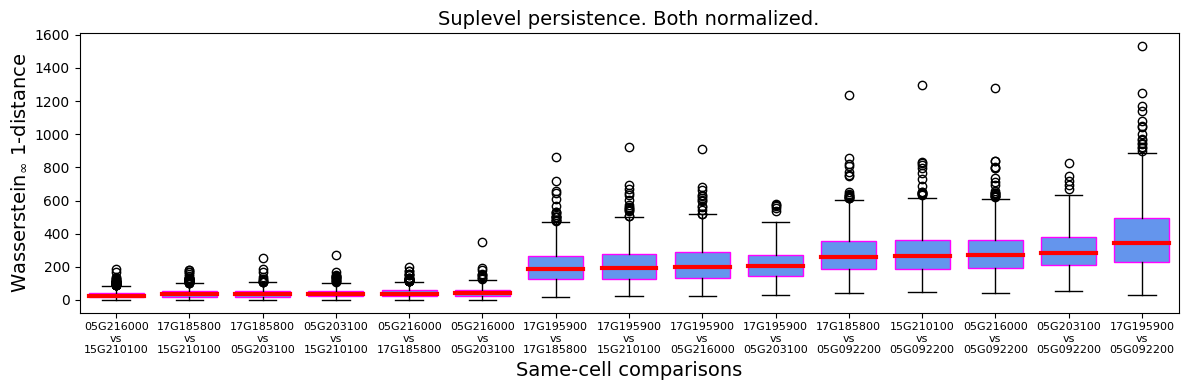

In [5]:
medgene = ws1.median(axis='index', skipna=True)
bsort = np.argsort(medgene.values)
boxes = [None for i in range(len(bsort))]
for i in range(len(boxes)):
    boxes[i] = ws1[columns[bsort[i]]].loc[~pd.isna(ws1[columns[bsort[i]]])].values

fig, ax = plt.subplots(1,1, figsize=(12,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

bplot = ax[i].boxplot(boxes, **box_params)
ax[i].set_xticks(range(1,len(boxes)+1), [foo.replace('_-_vs_-_', '\nvs\n').replace('GLYMA_','') for foo in columns[bsort]], fontsize=8)
for patch in bplot['boxes']:
    patch.set_color('magenta')
    patch.set_facecolor('cornflowerblue')

ax[i].set_title(Bname, fontsize=fs)
ax[i].set_ylabel('Wasserstein$_{}$ {}-distance'.format(ws_p, ws_o), fontsize=fs)
ax[i].set_xlabel('Same-cell comparisons', fontsize=fs)

fig.tight_layout();
filename = figdst + 'infected24_ws{}d_{}_distribution_{}level_by_{}.svg'.format(ws_o, ws_p.replace('\\',''), level, normtype)
print(filename)
#plt.savefig(filename, format='svg', bbox_inches='tight')

In [6]:
med_gene_d = pd.DataFrame(np.zeros((len(Genes), len(Genes))), index=transcriptomes[Genes], columns=transcriptomes[Genes])
for i in range(len(medgene)):
    key = medgene.index[i]
    gi, gj = key.split('_-_vs_-_')
    med_gene_d.loc[gi,gj] = medgene[key]
med_gene_d += med_gene_d.T
med_gene_d

,GLYMA_17G195900,GLYMA_05G216000,GLYMA_17G185800,GLYMA_05G203100,GLYMA_15G210100,GLYMA_05G092200
GLYMA_17G195900,0.000000,197.851804,186.903631,205.843487,191.364091,343.288164
GLYMA_05G216000,197.851804,0.000000,37.019836,42.604492,26.245490,269.800411
GLYMA_17G185800,186.903631,37.019836,0.000000,33.651799,32.850140,262.102852
GLYMA_05G203100,205.843487,42.604492,33.651799,0.000000,36.582555,281.187617
GLYMA_15G210100,191.364091,26.245490,32.850140,36.582555,0.000000,265.247309
GLYMA_05G092200,343.288164,269.800411,262.102852,281.187617,265.247309,0.000000


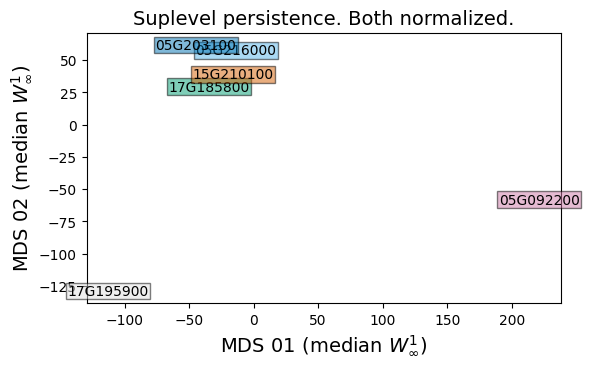

In [7]:
mds_params = {'n_components':2, 'metric':True, 'random_state':seed, 'dissimilarity':'precomputed', 'normalized_stress':False}
mds = manifold.MDS(**mds_params).fit_transform(med_gene_d)

fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(mds[:,0],mds[:,1], color=color[:len(mds)], alpha=0)
for j, text in enumerate(med_gene_d.columns.values):
    ax[i].text(mds[j,0], mds[j,1], text.replace('GLYMA_', ''), ha='center', va='center', 
               bbox={'facecolor':color[j], 'alpha': 0.5, 'pad': 1})
ax[i].set_aspect('equal')

ax[i].set_xlabel('MDS 01 (median $W_{}^{}$)'.format(ws_p, ws_o), fontsize=fs)
ax[i].set_ylabel('MDS 02 (median $W_{}^{}$)'.format(ws_p, ws_o), fontsize=fs)
ax[i].set_title(Bname, fontsize=fs)

fig.tight_layout();
filename = figdst + 'infected24_ws{}d_{}_mds_{}level_by_{}.svg'.format(ws_o, ws_p.replace('\\',''), level, normtype)
#plt.savefig(filename, format='svg', bbox_inches='tight')

In [8]:
mincell = ws1.min(axis='columns', skipna=True)
medcell = ws1.median(axis='columns', skipna=True)
maxcell = ws1.max(axis='columns', skipna=True)

gi, gj = 0,5
foo = ws1['{}_-_vs_-_{}'.format(transcriptomes[Genes[gi]], transcriptomes[Genes[gj]])]
csort = foo.sort_values().index
iloccsort = np.argsort(foo.values)

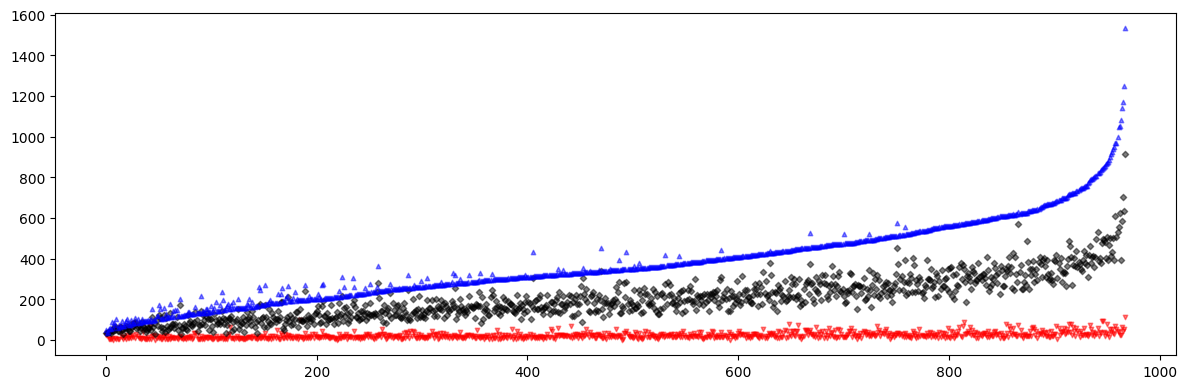

In [9]:
fig, ax = plt.subplots(1,1, figsize=(12,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for v, c, m in zip([mincell, medcell, maxcell],['r','k','b'], ['v','D','^']):
    ax[i].scatter(range(len(csort)), v.loc[csort], c=c, marker=m, alpha=0.5, s=10)

fig.tight_layout();

In [379]:
csort

Index([1418, 2430,  886, 2059,  608,  757, 1503, 2462, 1502, 2161,
       ...
        216, 1120, 2135,  629,  188, 1701, 2403, 2288, 1161, 1725],
      dtype='int64', name='ndimage_ID', length=968)

In [352]:
sidx = 968-5
cidx = Cells[iloccsort[sidx]]
metacell.loc[cidx, 'orig_cellID']

1702

In [333]:
reload(utils)
sidx = 968-5
#sidx = np.nonzero(metacell.loc[Cells[iloccsort], 'orig_cellID'].values == 1726)[0][0]

cidx = Cells[iloccsort[sidx]]
cell, extent = utils.get_cell_img(cidx, metacell, wall, label, PP=PP)

dgm = [None for _ in range(len(orig_diags))]

if normtype == 'both':
    for i in range(len(dgm)):
        dgm[i] = orig_diags[i][iloccsort[sidx]][focus_dim]*rescale
elif normtype == 'gene':
    for i in range(len(dgm)):
        dgm[i] = orig_diags[i][iloccsort[sidx]][focus_dim]*rescale[i][0][0]
        
key = '{}_-_{}_-_vs_-_{}'.format(csort[sidx], transcriptomes[Genes[gi]], transcriptomes[Genes[gj]])
w1 = ws1.loc[Cells[iloccsort[sidx]], '{}_-_vs_-_{}'.format(transcriptomes[Genes[gi]],transcriptomes[Genes[gj]])]
print(key, w1, sep='\n')

if key in dmatch:
    xy = utils.get_diagram_match_coordinates(dgm[gi], dgm[gj], dm=dmatch[key])

aux = 0
for j in range(len(dgm)):
    if len(dgm[j]) > 0:
        if aux < np.max(dgm[j]):
            aux = np.max(dgm[j])
aux += PP

1701_-_GLYMA_17G195900_-_vs_-_GLYMA_05G092200
1080.9614811600031


In [334]:
for jx in [0,5]:
    axes, grid, gmask, cgrid, cgridmask = utils.cell_grid_preparation(cell, extent, zmax, stepsize)
    cmask = label[translocs[Genes[jx]]['Y'], translocs[Genes[jx]]['X'] ] == cidx
    coords = translocs[Genes[jx]].iloc[ cmask ].values.T
    w = weight[tcumsum[Genes[jx]]:tcumsum[Genes[jx]+1]][cmask]
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T, w).evaluate(grid)
    kde = kde[gmask]/( np.sum(kde[gmask]) * (stepsize**len(coords)) )
    kde[ cgridmask ] = 0
    kde = kde/( np.sum(kde) * (stepsize**len(coords)) )
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
    zhist, _ = np.histogram(coords[2], bins=zbins, density=True)
    zlevel = np.argmax(zhist)
    
    sc = w_r*np.max(zhist)/zbins[-2]
    fig, ax = plt.subplots(1,4, figsize=(12,4), sharex=False, sharey=False, width_ratios=[1,w_r,w_r,w_r])
    ax = np.atleast_1d(ax).ravel(); i = 0
    
    ax[i].barh(sc*zbins[:-1]+stepsize*sc*0.5, zhist, 0.99*stepsize*sc,  color=color[jx])
    ax[i].plot(zhist, sc*zbins[:-1],  c='k', ds='steps')
    ax[i].set_yticks(sc*zbins[:-1:4], zbins[:-1:4])
    ax[i].set_xticks([0, zhist.max()], np.round( [0, zhist.max()], 3))
    ax[i].invert_xaxis();
    
    i += 1
    ax[i].imshow(cell, cmap='binary_r', origin='lower', extent=extent, vmin=0, vmax=2);
    ax[i].scatter(coords[0], coords[1], c=coords[2], cmap=cmap[jx], marker=marker[jx], vmax=zmax, vmin=0, edgecolor='k', linewidth=mew)
    ax[i].set_facecolor('#808080')
    ax[i].set_title('Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']), fontsize=fs)
    ax[i].set_xlabel(transcriptomes[Genes[jx]] + '   [ N = {} ]'.format(len(coords[0])), fontsize=fs)
    
    i += 1
    ax[i].contourf(axes[0]+extent[0], axes[1]+extent[2], kde[zlevel,:,:], 16, cmap='plasma', vmin=0, zorder=1)
    ax[i].set_facecolor('#0d0887')
    ax[i].set_title('${}\leq$ Z-level $< {}$'.format(*axes[2][zlevel:zlevel+2]), fontsize=fs)
    ax[i].set_xlabel('{} normalized'.format(normtype), fontsize=fs)
    for j in [1,2]:
        ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
    i += 1
    ax[i].scatter(dgm[jx][:,0], dgm[jx][:,1], marker=marker[jx], c=color[jx], s=ms, linewidth=mew, edgecolor='k', zorder=2)
    ax[i].scatter([0, aux] , [0, aux] , alpha=0, s=300)#; 
    ax[i].axline(xy1=(0,0), slope=1, c='k', zorder=3, lw=3)
    ax[i].axhline(0, c='k', zorder=3, lw=2)
    ax[i].axvline(0, c='k', zorder=3, lw=2)
    ax[i].set_facecolor('snow')
    ax[i].set_xlabel('Birth', fontsize=fs)
    ax[i].set_ylabel('Death', rotation=270, ha='center', va='top', fontsize=fs)
    ax[i].set_title('$H_{}$ {}level persistence'.format(focus_dim, level.title()) , fontsize=fs)
    ax[i].yaxis.set_label_position("right")
    ax[i].yaxis.tick_right()
    
    for i in range(len(ax)):
        ax[i].set_aspect('equal', 'datalim')
        ax[i].tick_params(labelsize=fs-3)
        ax[i].margins(x=0.1, y=0)
        
    
    fig.align_xlabels()
    fig.subplots_adjust(wspace=0.1, hspace=0)
    #fig.tight_layout()
    
    foo = [ sample, transcriptomes[Genes[jx]], level, normtype, metacell.loc[cidx, 'orig_cellID'] ]
    filename = figdst + '{}_{}_z_kde_pd_{}level_by_{}_{:05d}'.format(*foo)
    print(filename)
    plt.savefig(filename+'.jpg', format='jpg', dpi=150, bbox_inches='tight', pil_kwargs={'optimize':True})
    plt.close()

/home/eah4d/documents/website/mcarto/figs/D2_GLYMA_17G195900_z_kde_pd_suplevel_by_both_01702
/home/eah4d/documents/website/mcarto/figs/D2_GLYMA_05G092200_z_kde_pd_suplevel_by_both_01702


/home/eah4d/documents/website/mcarto/figs/D2_ws1d_infty_suplevel_by_both_01702


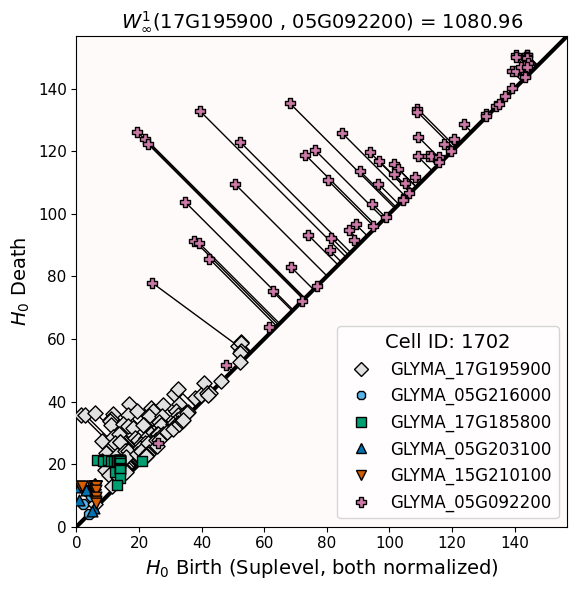

In [335]:
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for j in range(len(dgm)):
    ax[i].scatter(dgm[j][:,0], dgm[j][:,1], alpha=1,
                  marker=marker[j], c=color[j], s=ms, linewidth=mew, edgecolor='k', zorder=j+4)

for j in range(len(xy)):
    ax[i].plot([ xy[j,0], xy[j,2] ], [ xy[j,1], xy[j,3] ], c='k', zorder=1, alpha=1, ls='-', lw=1)

ax[i].scatter([0, aux] , [0, aux] , alpha=0); ax[i].margins(0)
ax[i].set_aspect('equal')
ax[i].axline(xy1=(0,0), slope=1, c='k', zorder=3, lw=3)
ax[i].tick_params(labelsize=fs-3)
ax[i].set_facecolor('snow')
ax[i].legend(handles, transcriptomes[Genes], loc='lower right', fontsize=fs-2, title_fontsize=fs,
             title='Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']))
ax[i].set_xlabel('$H_{}$ Birth ({}level, {} normalized)'.format(focus_dim, level.title(), normtype), fontsize=fs)
ax[i].set_ylabel('$H_{}$ Death'.format(focus_dim), fontsize=fs)

foo = [ws_p, ws_o] + [transcriptomes[Genes[j]].replace('GLYMA_','') for j in [gi,gj]] + [w1]
ax[i].set_title('$W_{}^{}$({} , {}) = {:.2f}'.format(*foo) , fontsize=fs)

fig.tight_layout()
foo = [sample, ws_o, ws_p.replace('\\',''), level, normtype, metacell.loc[cidx, 'orig_cellID'] ]
filename = figdst + '{}_ws{}d_{}_{}level_by_{}_{:05d}'.format(*foo)
print(filename)
plt.savefig(filename+'.svg', format='svg', bbox_inches='tight')

# Isn't it all about number of transcripts?

In [435]:
tnum = [None for _ in range(len(Genes))]
for jx in range(len(density)):
    den = transcell.loc[transcriptomes[Genes[jx]]]
    tnum[jx] = den.loc[csort.astype(str)]

density = [None for _ in range(len(Genes))]
for jx in range(len(density)):
    den = transcell.loc[transcriptomes[Genes[jx]]] /metacell['cyto_area'].values
    density[jx] = den.loc[csort.astype(str)]

foo = ws1['{}_-_vs_-_{}'.format(transcriptomes[Genes[gi]], transcriptomes[Genes[gj]])]
foo = foo.sort_values()

/home/eah4d/documents/website/mcarto/figs/D2_ws1d_infty_spearman_suplevel_by_both


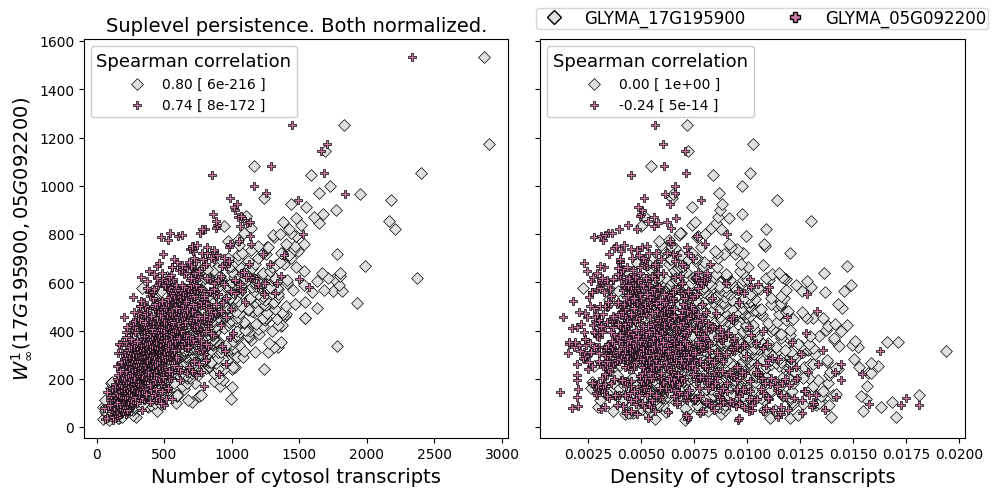

In [436]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=False, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
xlab = ['Number of cytosol transcripts', 'Density of cytosol transcripts']
for i,vals in enumerate([tnum, density]):
    for jx in [gi,gj]:
        res = stats.spearmanr(vals[jx], foo)
        label = '{:.2f} [ {:.0e} ]'.format(res.statistic, res.pvalue)
        ax[i].scatter(vals[jx].values, foo.values, c=color[jx], marker=marker[jx],
                      edgecolor='k', linewidth=0.5, label=label)
    
    ax[i].legend(fontsize=10, framealpha=1, title='Spearman correlation', title_fontsize=13, loc='upper left')
    ax[i].set_xlabel(xlab[i], fontsize=fs)

bar = [ws_p, ws_o] + [transcriptomes[Genes[j]].replace('GLYMA_','') for j in [gi,gj]]
ax[0].set_ylabel('$W_{}^{}({},{})$'.format(*bar), fontsize=fs)
ax[0].set_title(Bname, fontsize=fs)
fig.legend([handles[gi],handles[gj]], transcriptomes[Genes[[gi,gj]]], ncols=2, fontsize=12, loc='upper right', borderpad=0.1)

fig.tight_layout();

bar = [sample, ws_o, ws_p.replace('\\',''), level, normtype, metacell.loc[cidx, 'orig_cellID'] ]
filename = figdst + '{}_ws{}d_{}_spearman_{}level_by_{}'.format(*bar)
print(filename)
plt.savefig(filename+'.jpg', format='jpg', dpi=150, bbox_inches='tight', pil_kwargs={'optimize':True})

# Color the whole cross-section by Wasserstein similarity

In [282]:
gi, gj = 0,5
diff = ws1['{}_-_vs_-_{}'.format(transcriptomes[Genes[gi]], transcriptomes[Genes[gj]])].sort_values()
cellloc = metacell.loc[diff.index, ['ndimage_comX', 'ndimage_comY']]

In [283]:
alpha = 0.025

vmin,vmax = np.quantile(diff.values, [alpha,1-alpha])
q1, q3 = np.quantile(diff.values, [0.25, 0.75])
iqr = q3 - q1

vmin = max([diff.min(), q1-iqr])
vmax = min([diff.max(), q3+iqr])

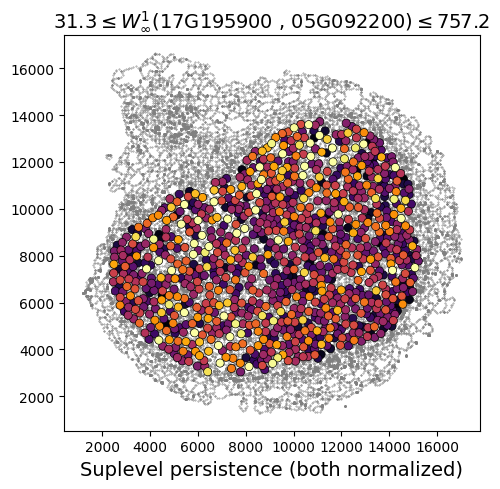

In [284]:
s = 35

fig, ax = plt.subplots(1,1, figsize=(5,5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
ax[i].scatter(cellloc['ndimage_comX'], cellloc['ndimage_comY'], c=diff.values, cmap='inferno', marker='o',
              vmin=vmin, vmax=vmax, s=s, edgecolor='black', linewidth=0.5, zorder=2)
foo = [vmin, '\\' + ws_p, ws_o] + [transcriptomes[Genes[j]].replace('GLYMA_','') for j in [gi,gj]] + [vmax]
ax[i].set_title('{:.1f}$\leq W_{}^{}$({} , {})$\leq${:.1f}'.format(*foo) , fontsize=fs)
ax[i].set_xlabel('{}level persistence ({} normalized)'.format(level.title(), normtype), fontsize=fs)

fig.tight_layout();

filename = figdst + '{}_ws{}d_{}_difference_{}level_by_{}'.format(sample, ws_o, ws_p, level, normtype)
plt.savefig(filename+'.jpg', format='jpg', dpi=150, bbox_inches='tight', pil_kwargs={'optimize':True})

# Bring in persistence images to the party

In [285]:
diags, nzcumsum, nzmask = utils.reduce_num_of_diagrams(orig_diags, rescale, focus_dim, normtype, minlife=minlife, keepall=False)
print(list(map(len, diags)))

Non-zero diagrams:	5005
Compared to all diagrams:	5808	[86.17%]
[968, 919, 933, 275, 942, 968]


In [314]:
sigma = 1
pers_w = 1
pixel_size = 4

foo = [isrc, level, 'gene', int(sigma), pers_w, pixel_size, os.sep]
psrc = '{}{}level_-_by_{}_-_sigma_{}_-_pers+n_{}_-_pixel+size_{}{}'.format(*foo)

method = 'UMAP'
npy_files = sorted(glob(psrc + method.lower() + '*.npy'))
for i in range(len(npy_files)):
    print(i, os.path.split(npy_files[i])[1], sep='\t')

0	umap_-_n+neighbors_12_-_min+dist_0.0_-_metric_chebyshev_-_with+std_False.npy
1	umap_-_n+neighbors_12_-_min+dist_0.0_-_metric_chebyshev_-_with+std_True.npy
2	umap_-_n+neighbors_12_-_min+dist_0.0_-_metric_euclidean_-_with+std_False.npy
3	umap_-_n+neighbors_12_-_min+dist_0.0_-_metric_euclidean_-_with+std_True.npy
4	umap_-_n+neighbors_12_-_min+dist_0.0_-_metric_manhattan_-_with+std_False.npy
5	umap_-_n+neighbors_12_-_min+dist_0.0_-_metric_manhattan_-_with+std_True.npy
6	umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_chebyshev_-_with+std_False.npy
7	umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_chebyshev_-_with+std_True.npy
8	umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_euclidean_-_with+std_False.npy
9	umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_euclidean_-_with+std_True.npy
10	umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_manhattan_-_with+std_False.npy
11	umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_manhattan_-_with+std_True.npy
12	umap_-_n+neighbors_24_-_min+dist_0.0_-_metric_chebysh

In [315]:
npy = 9
print( os.path.split(npy_files[npy])[1] )
foo = os.path.splitext(os.path.split(npy_files[npy])[1])[0].split('_-_')[1:]
params_kws = [ bar.split('_')[0].replace('+', '_') for bar in foo ]
params_vals= [ bar.split('_')[1].replace('+', '_') for bar in foo ]
embed_params = dict(zip(params_kws,params_vals))
embedding = np.load(npy_files[npy], allow_pickle=True)
print(list(map(len, diags)))
np.sum(list(map(len, diags))) == len(embedding)

umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_euclidean_-_with+std_True.npy
[968, 919, 933, 275, 942, 968]


False

In [316]:
def plot_embedding(nzcumsum, titles, embedding, alpha=0.05, label=None, nrows=2, ncols=4, ticks=False, colors=color[1:], markers=marker):
    
    q1, q3 = np.quantile(embedding[:,:2], [alpha, 1-alpha], axis=0)
    iqr = q3 - q1
    mn = np.maximum( q1 - 1.5*iqr, np.min(embedding[:,:2], axis=0) )
    mx = np.minimum( q3 + 1.5*iqr, np.max(embedding[:,:2], axis=0) )
        
    fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols,2*nrows+1), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    for i in range(len(nzcumsum) - 1):
        ax[i].scatter(embedding[:,0], embedding[:,1], c='gray', marker='.', alpha=0.15, zorder=1)
        ax[i].set_facecolor('snow')
        s_ = np.s_[nzcumsum[i]:nzcumsum[i+1]]
        ax[i].scatter(embedding[s_,0], embedding[s_,1], c=colors[i], marker=markers[i], 
                      edgecolor='k', linewidth=0.5, alpha=0.5, zorder=2)
        ax[i].set_title(titles[i])
        ax[i].set_xlim(mn[0],mx[0])
        ax[i].set_ylim(mn[1],mx[1])
        ax[i].tick_params(left=ticks, labelleft=ticks, labelbottom=ticks, bottom=ticks);
    
    for i in range( len(ax) - len(nzcumsum)+1 , 0, -1):
        fig.delaxes(ax[-i])

    if label is not None:
        fig.supxlabel(label + ' 01')
        fig.supylabel(label + ' 02')
    
    fig.tight_layout();

    return fig, ax, mn, mx

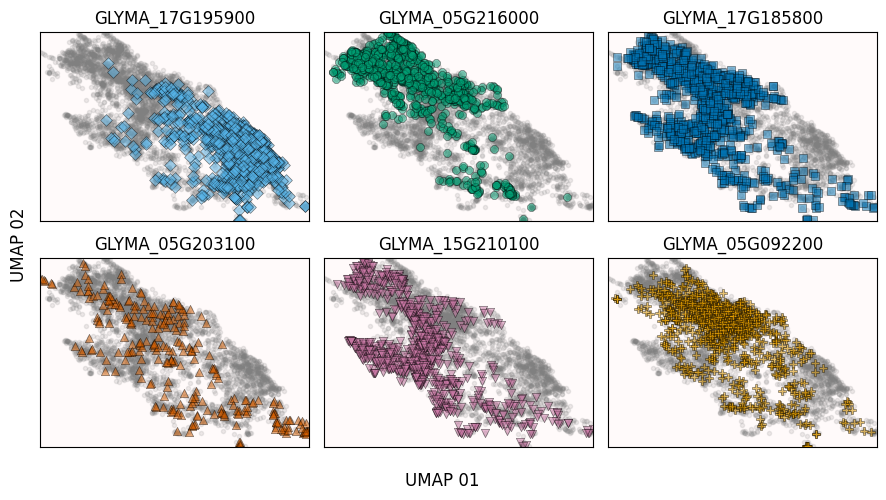

In [317]:
_,_,mn,mx = plot_embedding(nzcumsum, transcriptomes[Genes], embedding, 0.01, 'UMAP', nrows=2, ncols=3);

In [309]:
gidx = 1
s_ = np.s_[nzcumsum[gidx]:nzcumsum[gidx+1]]
pts = embedding[s_, :2]

dbscan_params = {'eps': 0.1, 'min_samples': 3, 'metric': embed_params['metric'], 'n_jobs':1}
dbscan = cluster.DBSCAN(**dbscan_params).fit(pts)
labs = np.unique(dbscan.labels_)
labs

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [305]:
def print_clust(clust):
    fig, ax = plt.subplots(2,5, figsize=(12,5), sharex=False, sharey=False)
    ax = np.atleast_1d(ax).ravel(); i = 0
    
    for i in range(min( [ len(ax), len(clust) ])):
        cidx = clust[i]
        cell, extent = get_cell_img(cidx)
        coords = translocs[Genes[gidx]].iloc[ label[translocs[Genes[gidx]]['Y'], translocs[Genes[gidx]]['X'] ] == cidx].values.T
        ax[i].imshow(cell, cmap='binary_r', origin='lower', extent=extent, vmin=0, vmax=2);
        ax[i].scatter(coords[0], coords[1], c=coords[2], cmap='Blues_r', marker=marker[jx], vmax=50, vmin=0, edgecolor='k', linewidth=mew, s=s)
        ax[i].set_facecolor('#808080')
        #coords = translocs[Genes[0]].iloc[ label[translocs[Genes[0]]['Y'], translocs[Genes[0]]['X'] ] == cidx].values.T
        #ax[i].scatter(coords[0], coords[1], c=coords[2], cmap='Reds_r', marker=marker[jx], vmax=50, vmin=0, edgecolor='k', linewidth=mew, s=25)
        ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        ax[i].set_title('ID: {} [ N = {} ]'.format(metacell.loc[cidx, 'orig_cellID'], len(coords[0])), fontsize=fs)
        ax[i].set_aspect('equal','datalim')
    fig.tight_layout();

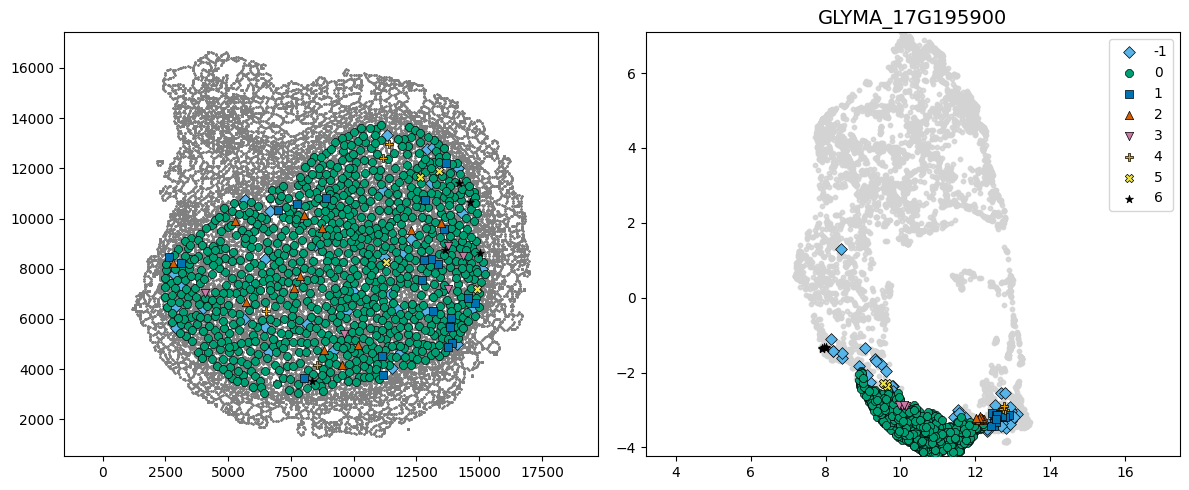

In [310]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

for j in range(len(labs)):
    i = 1
    ax[i].scatter(embedding[:,0], embedding[:,1], c='lightgray', marker='.', alpha=0.15, zorder=1)
    ax[i].scatter(*(pts[dbscan.labels_ == labs[j]].T), color=color[j+1], marker=marker[j], zorder=4,
                  edgecolor='k', linewidth=0.5, label=labs[j])
    i = 0
    cellloc = metacell.loc[Cells[ nzmask[gidx][ dbscan.labels_ == labs[j] ] ], ['ndimage_comX', 'ndimage_comY']]
    ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
    ax[i].scatter(cellloc['ndimage_comX'], cellloc['ndimage_comY'], c=color[j+1], marker=marker[j], 
                  edgecolor='black', linewidth=0.5, zorder=2)
i = 1
ax[i].legend()
ax[i].set_xlim(mn[0],mx[0])
ax[i].set_ylim(mn[1],mx[1])
ax[i].set_title(transcriptomes[Genes[gidx]], fontsize=fs)
for i in range(len(ax)):
    ax[i].set_aspect('equal','datalim')

fig.tight_layout();

22


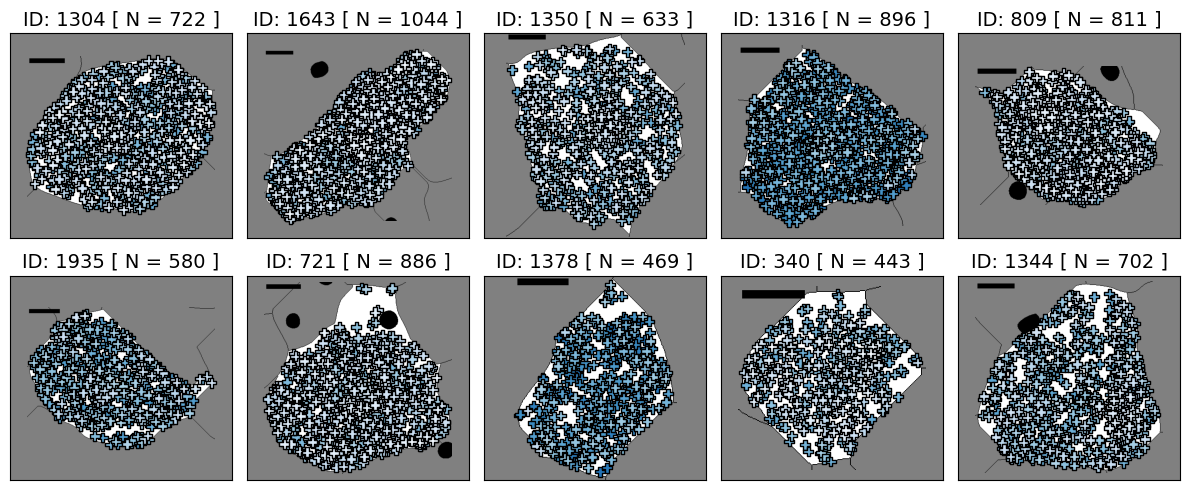

In [311]:
s = 50
clust = Cells[ nzmask[gidx][ dbscan.labels_ == 1 ] ]
print(len(clust))
print_clust(clust)

4


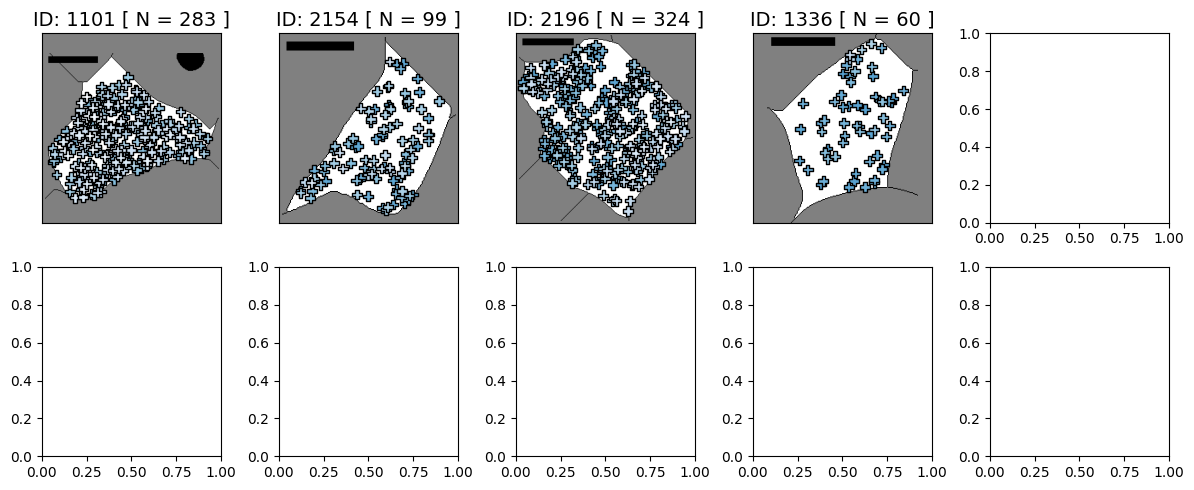

In [312]:
clust = Cells[ nzmask[gidx][ dbscan.labels_ == 5 ] ]
print(len(clust))
print_clust(clust)

5


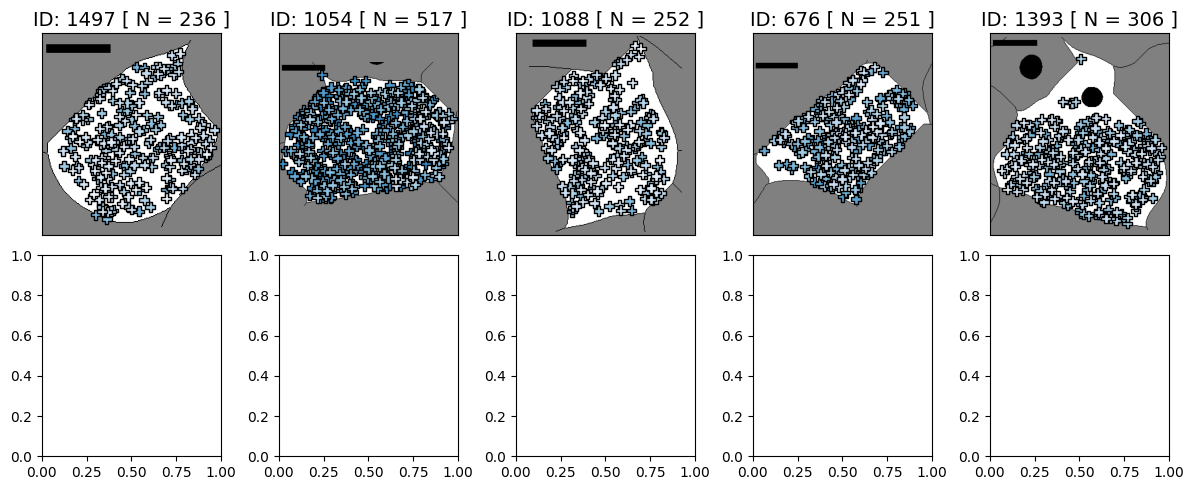

In [313]:
clust = Cells[ nzmask[gidx][ dbscan.labels_ == 3 ] ]
print(len(clust))
print_clust(clust)

12


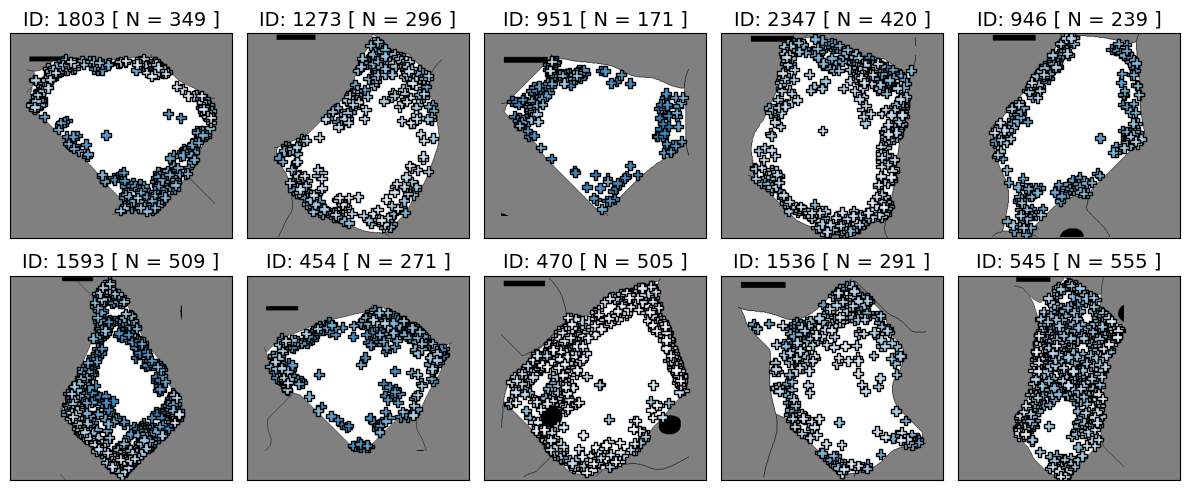

In [217]:
clust = Cells[ nzmask[gidx][ dbscan.labels_ == -1 ] ]
print(len(clust))
print_clust(clust)

# Explore